In [1]:
import sys
sys.path.append("/Users/mistryk2/Packages/nudobe/src/")
sys.path.append("/Users/mistryk2/Packages/nudobe/")

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from nudobe import EFT
from EFT import LEFT

from nudobe import constants, functions
from constants import *

#import neutrino mixing matrix function
from functions import U_PMNS

#import multiprocessing

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D


import matplotlib.cm as cm
import time
import pandas as pd
plt.rc('text', usetex=False)

In [2]:
# Get the Dark2 colormap
cmap = cm.get_cmap('Dark2')

nbins = 100
eps = 1e-5 #avoid poles
nevts = 1000000

Q = 2.457984 # Q-value in MeV units
me = 0.51099895 # electron mass in MeV units

NME="SM"
# NME="IBM2"
# NME="QRPA"

rho_spec_vec  = []
rho_angle_vec = []


Models = []
Labels = []

# Add a wilson coeficient
# Models.append(EFT.LEFT({"VR(6)" : 1e-6, "m_bb" : 28*meV}, name = f"VR(6) {NME} Model", method = NME))
# Labels.append(r"$m_{\beta \beta}$ + VR(6)")

Models.append(EFT.LEFT({"VL(6)" : 1e-6, "m_bb" : 28*meV}, name = f"VL(6) {NME} Model", method = NME))
Labels.append(r"$m_{\beta \beta} + C_{VL}^{(6)}$")

# Add standard mechanism to compare to
Models.append(EFT.LEFT({"m_bb" : 28*meV}, name = f"mbb {NME} Model", method = NME))
Labels.append(r"$m_{\beta \beta}$")

In [3]:
# Calculate momentum from kinetic energy
def p_fun(t): # valid for both e1 and e2
    p = np.sqrt(t*(t+2.*me))
    return p

In [4]:
# Define normalized energy array
ebar_vec = np.linspace(0+eps, 1-eps, nbins)

# Define array of electron kinetic energies and electron momenta
# ebar = (E_e - m_e)/Q = T_e/Q -> T_e = ebar*Q
t_vec = ebar_vec*Q
#print(t_vec)
p_vec = p_fun(t_vec)

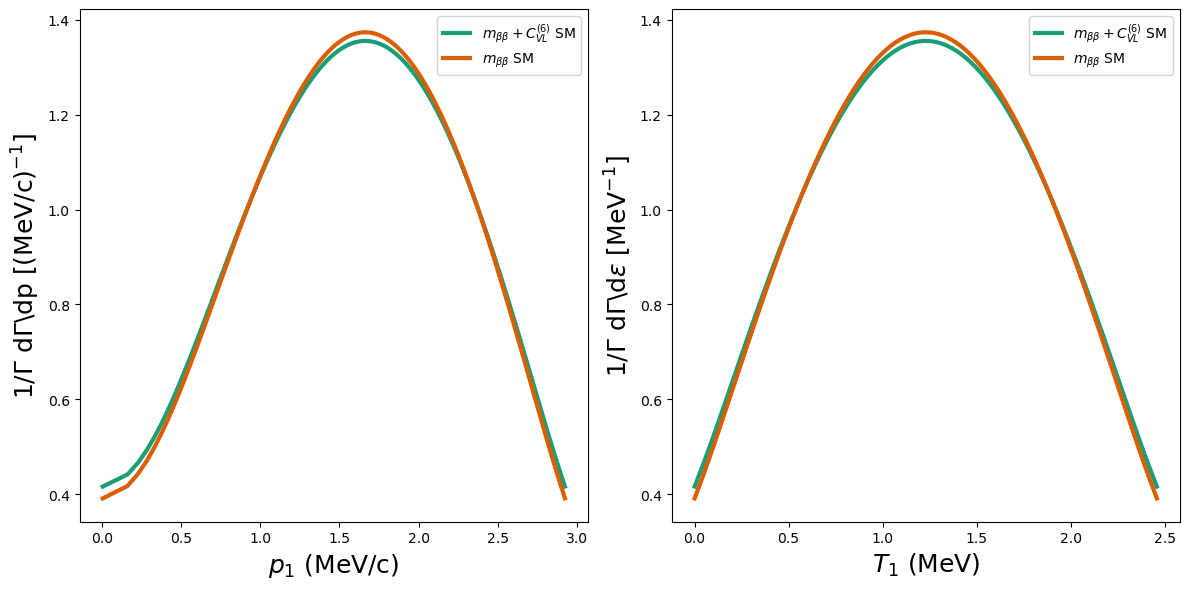

In [39]:
fig = plt.figure(figsize=(12, 6))

colors = [cmap(i) for i in range(5)]
colors.append("k")

for m in range(len(Models)):

    rho_spec_vec.append(Models[m].spectrum(ebar_vec,isotope="136Xe"))
    name = fr"{Labels[m]} {NME}"

    plt.subplot(121)
    plt.plot(p_vec, rho_spec_vec[m]/sum(rho_spec_vec[m])*nbins, linewidth=3,label = name, color = colors[m])
    plt.xlabel(r'$p_1$ (MeV/c)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\dp [(MeV/c)$^{-1}$]", fontsize=18)
    plt.legend()

    plt.subplot(122)
    plt.plot(t_vec, rho_spec_vec[m]/sum(rho_spec_vec[m])*nbins, linewidth=3,label = name, color = colors[m])
    plt.xlabel(r'$T_1$ (MeV)', fontsize=18)
    plt.ylabel("1/$\Gamma$ d$\Gamma$\d$\epsilon$ [MeV$^{-1}$]", fontsize=18)
    plt.legend()

    plt.tight_layout()
    

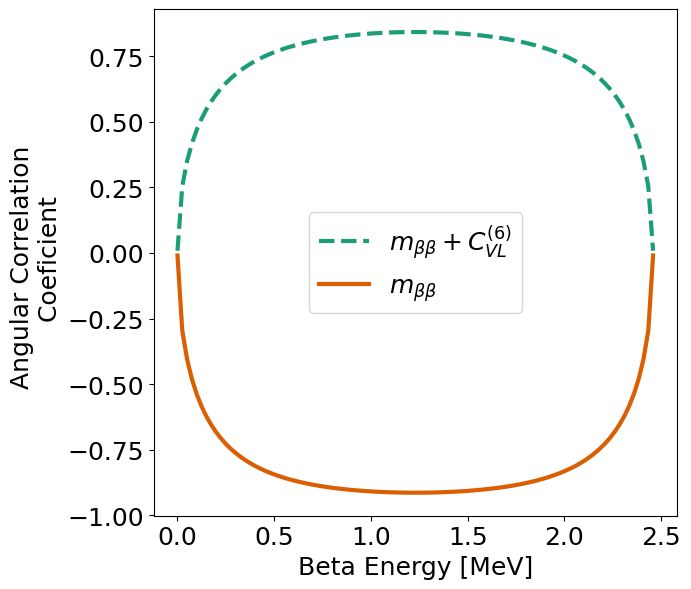

In [6]:
fig = plt.figure(figsize=(7, 6))

for m in range(len(Models)):

    rho_angle_vec.append(Models[m].angular_corr(ebar_vec,isotope="136Xe"))

    name = f"{Labels[m]}"

    # plt.subplot(122)
    if (m == 1):
        plt.plot(t_vec, rho_angle_vec[m], linewidth=3,label = name, color = colors[m])
    else:
        plt.plot(t_vec, rho_angle_vec[m], linewidth=3,label = name, color = colors[m], linestyle="--")
    plt.xlabel('Beta Energy [MeV]', fontsize=18)
    plt.ylabel("Angular Correlation \n Coeficient", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

    plt.tight_layout()
    plt.savefig("../files/plots/WCs/C_VL6_nudobe.png", dpi=200)

In [7]:
t1_vec = []
t2_vec = []

for m in range(len(Models)):

    # Find maximum, for random generation along y axis for accept-reject method
    rho_spec_max = np.max(rho_spec_vec[m])
    print("rho_spec_max = ", rho_spec_max)

    p_max = p_fun(Q)
    print(p_max)
    t_max = Q
    print(t_max)

    rho_spec_fun = interp1d(t_vec, rho_spec_vec[m], kind='linear', fill_value=(rho_spec_vec[m][0],rho_spec_vec[m][-1]), bounds_error=False)

    t1_vec.append(np.zeros(nevts))
    t2_vec.append(np.zeros(nevts))

    ievt = 0

    while ievt < nevts:

        # Random number from 0 to Q-val
        t1 = np.random.uniform(low = 0., high = t_max)
        p1 = p_fun(t1)
        t2 = Q - t1
        p2 = p_fun(t2)
        
        if (t1 < 0 or t2 < 0 or t1 > t_max or t2 > t_max):
            print(t1,t2)
        
        f = np.random.uniform(low=0., high=rho_spec_max)  
    
        if (f < rho_spec_fun(t1)):
            t1_vec[m][ievt] = t1 # MeV units
            t2_vec[m][ievt] = t2 # MeC units
            ievt += 1
            
    print("# accepted = ", ievt, " over ", nevts)

rho_spec_max =  1.3607179377654993e-21
2.9246777310482606
2.457984
# accepted =  1000000  over  1000000
rho_spec_max =  1.4356014749100583e-27
2.9246777310482606
2.457984
# accepted =  1000000  over  1000000


In [8]:
def cos12_fun(theta1, phi1, theta2, phi2): #cos12 = (p1x*p2x + p1y*p2y + p1z*p2z) / (p1*p2)
    x = np.sin(theta1)*np.cos(phi1) * np.sin(theta2)*np.cos(phi2)
    y = np.sin(theta1)*np.sin(phi1) * np.sin(theta2)*np.sin(phi2)
    z = np.cos(theta1) * np.cos(theta2)
    return x+y+z

In [9]:
def eta_fun(ebar,theta1,phi1,theta2,phi2,rho_angle_fun):
    eta = 1 + rho_angle_fun(ebar)*cos12_fun(theta1,phi1,theta2,phi2)
    return eta

In [10]:
theta1_vec = []
theta2_vec = []
phi1_vec = []
phi2_vec = []
p1_vec = []
p2_vec = []

for m in range(len(Models)):

    rho_angle_fun = interp1d(ebar_vec, rho_angle_vec[m], kind='linear', fill_value=(rho_angle_vec[m][0],rho_angle_vec[m][-1]), bounds_error=False)

    theta1_vec.append(np.zeros(nevts))
    theta2_vec.append(np.zeros(nevts))
    phi1_vec.append(np.zeros(nevts))
    phi2_vec.append(np.zeros(nevts))

    ievt = 0

    # Get vector of p1, p2, beta1 and beta2 values
    p1_vec.append(p_fun(t1_vec[m]))
    p2_vec.append(p_fun(t2_vec[m]))


    while ievt < nevts:
        
        t1 = t1_vec[m][ievt]
        ebar = t1/Q
        # eta_max is for costheta=-1 or costheta=+1, depending on the sign of rho_angle_fun
        eta_max = max(1 - rho_angle_fun(ebar), 1 + rho_angle_fun(ebar))
        #print(ebar,eta_max)
        
        # Note: the cosine of polar angles need to be generated uniformly between -1 and +1. 
        costheta1 = np.random.uniform(low = -1., high = +1.)
        theta1 = np.arccos(costheta1)
        phi1 = np.random.uniform(low = 0., high = 2.*np.pi)
        
        costheta2 = np.random.uniform(low = -1., high = +1.)
        theta2 = np.arccos(costheta2)
        phi2 = np.random.uniform(low = 0., high = 2.*np.pi)
        
        f = np.random.uniform(low=0., high=eta_max) 
    
        if (f < eta_fun(ebar,theta1,phi1,theta2,phi2,rho_angle_fun)):
            theta1_vec[m][ievt] = theta1 
            phi1_vec[m][ievt] = phi1
            theta2_vec[m][ievt] = theta2 
            phi2_vec[m][ievt] = phi2
            ievt += 1
            
    print("# accepted = ", ievt, " over ", nevts)


# accepted =  1000000  over  1000000
# accepted =  1000000  over  1000000


In [11]:
p1x_vec = []
p1y_vec = []
p1z_vec = []
p2x_vec = []
p2y_vec = []
p2z_vec = []

for m in range(len(Models)):
    p1x_vec.append(np.zeros(nevts))
    p1y_vec.append(np.zeros(nevts))
    p1z_vec.append(np.zeros(nevts))

    p2x_vec.append(np.zeros(nevts))
    p2y_vec.append(np.zeros(nevts))
    p2z_vec.append(np.zeros(nevts))


    for ievt in range(nevts):
        p1x_vec[m][ievt] = p1_vec[m][ievt]*np.sin(theta1_vec[m][ievt])*np.cos(phi1_vec[m][ievt])
        p1y_vec[m][ievt] = p1_vec[m][ievt]*np.sin(theta1_vec[m][ievt])*np.sin(phi1_vec[m][ievt]) 
        p1z_vec[m][ievt] = p1_vec[m][ievt]*np.cos(theta1_vec[m][ievt])

        norm1 = np.linalg.norm([p1x_vec[m][ievt],p1y_vec[m][ievt],p1z_vec[m][ievt]])

        p1x_vec[m][ievt] = p1x_vec[m][ievt]/norm1
        p1y_vec[m][ievt] = p1y_vec[m][ievt]/norm1
        p1z_vec[m][ievt] = p1z_vec[m][ievt]/norm1

        
        p2x_vec[m][ievt] = p2_vec[m][ievt]*np.sin(theta2_vec[m][ievt])*np.cos(phi2_vec[m][ievt])
        p2y_vec[m][ievt] = p2_vec[m][ievt]*np.sin(theta2_vec[m][ievt])*np.sin(phi2_vec[m][ievt]) 
        p2z_vec[m][ievt] = p2_vec[m][ievt]*np.cos(theta2_vec[m][ievt])

        norm2 = np.linalg.norm([p2x_vec[m][ievt],p2y_vec[m][ievt],p2z_vec[m][ievt]])

        p2x_vec[m][ievt] = p2x_vec[m][ievt]/norm2
        p2y_vec[m][ievt] = p2y_vec[m][ievt]/norm2
        p2z_vec[m][ievt] = p2z_vec[m][ievt]/norm2


In [12]:
path = "../files/"
outnames = [f"VL_6_{NME}.txt"]

for m in range(len(outnames)):
    
    # Make a dataframe
    df = pd.DataFrame( {"x1_dir":p1x_vec[m], "y1_dir":p1y_vec[m], "z1_dir":p1z_vec[m], "e1": t1_vec[m], "x2_dir":p2x_vec[m], "y2_dir":p2y_vec[m], "z2_dir":p2z_vec[m], "e2": t2_vec[m]}  )
    df.to_csv(path+outnames[m], index=False, float_format='%.5f')


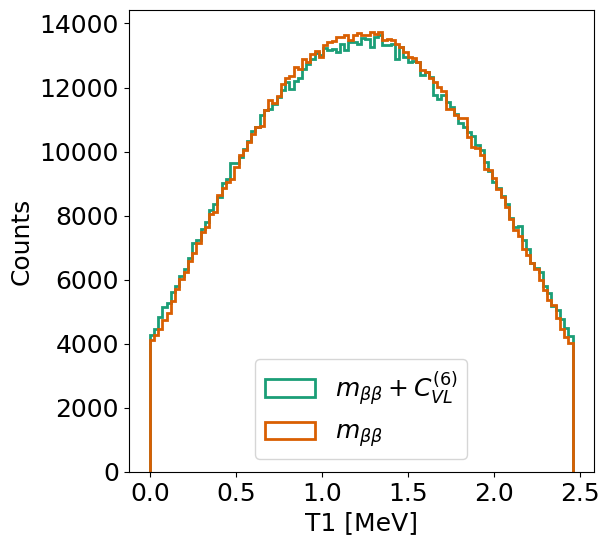

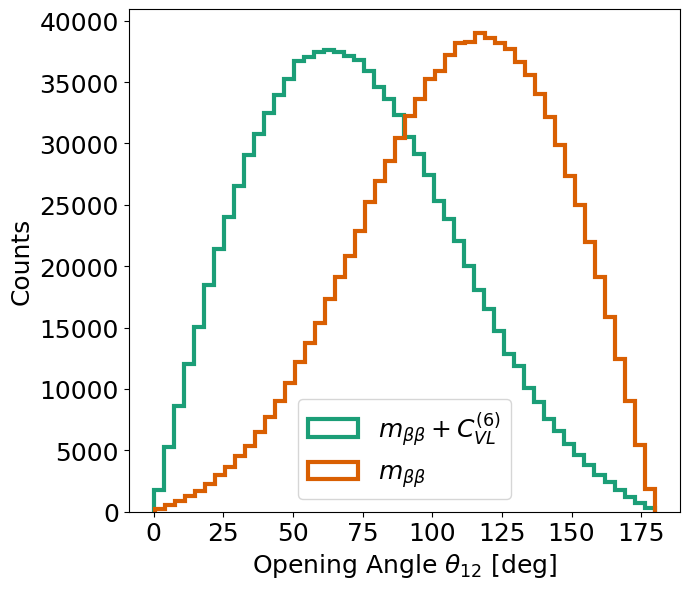

In [46]:
fig = plt.figure(figsize=(6, 6))

for m in range(len(Models)):

    name = f"{Labels[m]}"

    plt.hist(t1_vec[m], bins=100,label = name, color = colors[m], histtype = "step", linewidth = 2)
    plt.xlabel('T1 [MeV]', fontsize=18)
    plt.ylabel("Counts", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18, loc = "lower center")
    plt.savefig("../files/plots/WCs/C_VL6_nudobe_T1_events.png", dpi=200)

fig = plt.figure(figsize=(7, 6))
for m in range(len(Models)):

    cos12_vec = cos12_fun(theta1_vec[m], phi1_vec[m], theta2_vec[m], phi2_vec[m])

    name = f"{Labels[m]}"

    counts_costheta12, bins_costheta12, patches = plt.hist(np.arccos(cos12_vec)*180/np.pi, bins=50, label = name, color = colors[m], histtype = "step", linewidth = 3)
    plt.xlabel(r'Opening Angle $\theta_{12}$ [deg]', fontsize=18)
    plt.ylabel("Counts", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18, loc = "lower center")
    # plt.xlim(-1,1)

    plt.tight_layout()
    plt.savefig("../files/plots/WCs/C_VL6_nudobe_costheta_events.png", dpi=200)



    fig.tight_layout()
